# Restaurant Demo

PyDP version for Google's Java Differential Privacy Library example - https://github.com/google/differential-privacy/tree/master/examples/java.

Imagine a fictional restaurant owner named Alice who would like to share business statistics with her visitors. Alice knows when visitors enter the restaurant and how much time and money they spend there. To ensure that visitor's privacy is preserved, Alice decides to use the **Differential Privacy library**.

## Initial Setup

In [23]:
# Install the PyDP package
! pip install python-dp

In [24]:
import pydp as dp # by convention our package is to be imported as dp (for Differential Privacy!)
from pydp.algorithms.laplacian import BoundedSum, Count
import pandas as pd
import statistics # for calculating mean without applying differential privacy
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
print("Setup Complete")

Setup Complete


## Count visits by hour of day

In this example Alice wants to share this information with potential clients in order **to let them know the busiest times in the restaurant**. For this, we will ***count how many visitors enter the restaurant at every hour of a particular day***. For simplicity, assume that a visitor comes to the restaurant at most once a day. In other words, a visitor is present at most once in the whole dataset.

Visit data for a single day is stored in the **day_data.csv** file. It includes the visitor’s ID, the visit duration (in minutes), and the money spent at the restaurant.

In [26]:
url = 'https://raw.githubusercontent.com/OpenMined/PyDP/dev/examples/restaurant_demo/day_data.csv'
df = pd.read_csv(url,sep=",")
df.head()

,VisitorId,Time entered,Time spent (mins),Money spent (euros),Day
0,1,9:30:00 AM,26,24,1
1,2,11:39:00 AM,31,18,1
2,3,9:11:00 AM,46,22,1
3,4,11:37:00 AM,41,25,1
4,5,10:59:00 AM,25,16,1


We want to read the daily statistics and calculate the number of *visitors* that entered the restaurant *every hour* of the day. 

In [27]:
# Get the Visitor and time entered data into new DataFrame 
cols = ['VisitorId', 'Time entered']
new_df = df.loc[: , cols]
new_df.head()

,VisitorId,Time entered
0,1,9:30:00 AM
1,2,11:39:00 AM
2,3,9:11:00 AM
3,4,11:37:00 AM
4,5,10:59:00 AM


In [28]:
# check sample data
time = df.iloc[421,1]
time

'8:09:00 PM'

In [29]:
# function to convert time to 24 hrs format 

def convert_to_24hours(date) :
    dateInfo = date.split(' ')     #  ['8:09:00', 'PM']
    dateArr = dateInfo[0].split(':')  # ['8', '09', '00']
    hour = 0
    # for midnight
    if ((dateInfo[1] == 'AM') and (dateArr[0] == '12')):
        hour = 0
    # for 12 noon
    elif ((dateInfo[1] == 'PM') and (dateArr[0] == '12')):
        hour = 12
    # for AM and PM
    elif (dateInfo[1] == 'AM') :
        hour = int(dateArr[0])
    else:
        hour = int(dateArr[0]) + 12
    return hour

# check
hour24 = convert_to_24hours('1:23:34 PM')
print(hour24)

13


In [30]:
# Create a new column called partition with hour data in the new_df

partition = []

for time in df['Time entered']:   # convert timings into 24hrs format
    new = convert_to_24hours(time)
    partition.append(new)

    
new_df['Partition'] = partition  # add new column
new_df.tail()


,VisitorId,Time entered,Partition
445,446,8:10:00 PM,20
446,447,7:32:00 PM,19
447,448,7:50:00 PM,19
448,449,8:22:00 PM,20
449,450,7:22:00 PM,19


#### Restaurant Schedule

In [31]:
# An hour when visitors start entering the restaurant.
OPENING_HOUR = 9

#An hour when visitors stop entering the restaurant.
CLOSING_HOUR = 20

# For how many hours visitors can enter the restaurant.
NUM_OF_WORK_HOURS = CLOSING_HOUR - OPENING_HOUR + 1      # 12

# Range of valid work hours when a visitor can enter the restaurant.
VALID_HOURS = list(range(OPENING_HOUR, CLOSING_HOUR+1))  # [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

### Explanation
#### Partitions and contributions
We say that the resulting aggregated data is split into partitions. The bar chart for the private and non-private counts each have 12 partitions, one for each entry hour.

More generally, a single partition represents a subset of aggregated data corresponding to a given value of the aggregation criterion. Graphically, a single partition is represented as a bar on the aggregated bar chart.

We say that a visitor contributes to a given partition if their data matches the partition criterion. For example, if a visitor enters between 8 AM and 9 AM, they contribute to the 8 AM partition.

Recall that in the the example above, a visitor can enter the restaurant only once per day. This implies three contribution bounds:

- **Maximum partitions contributed**: to how many partitions can a visitor contribute? In our example, a visitor can contribute up to one partition. In other words, there is at most one time-slot when a visitor with a given id can enter the restaurant.
- **Maximum contributed value**: what is the maximum value that can be contributed by a visitor to a partition? In our example, we count the number of visits, so the maximum contributed value is simply 1.
- **Maximum contributions per partition**: how many times can a visitor contribute to a partition? In our example, a visitor can contribute to a partition at most once. In other words, a visitor can enter the restaurant only once at a given hour.

Why is this important? Differential Privacy adjusts the amount of noise to mask contributions of each visitor. More contributions require more noise.

### Defining Bar Plots for Original Data, Differentially Private data and their comparison

In [32]:
# bar plot - original data

def bar_plot(x,y,title,x_label,y_label):
    plt.subplots(figsize = (8,4))
    plt.bar(x, y, color = 'cornflowerblue')
    axes = plt.gca()
    axes.yaxis.grid()
    axes.set_axisbelow(True)
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(x)
    plt.show

In [33]:
# Bar plot - differentially private data 

def private_bar_plot(x,y,title,x_label,y_label):
    plt.subplots(figsize = (8,4))
    plt.bar(x, y, color = 'orangered')
    axes = plt.gca()
    axes.yaxis.grid()
    axes.set_axisbelow(True)
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(x)
    plt.show

In [34]:
# Comparison Bar plot

def comparison_graph(labels, x1, x2, rect1_label, rect2_label, x_label, title):
    x = np.arange(len(labels))  # the label locations
    width = 0.34  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(14,6))
    rects1 = ax.bar(x - width/2, x1, width, label= rect1_label, color='cornflowerblue', edgecolor = 'white')
    rects2 = ax.bar(x + width/2, x2, width, label= rect2_label, color='orangered', edgecolor = 'white')
    axes = plt.gca()
    axes.yaxis.grid()
    axes.set_axisbelow(True)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(x_label)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0,5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
            

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()  
   

### Count Per Hour 

In [35]:
# visitor contributes to a given partitions VALID_HOURS 
# In the given data 1 visitor contributes to only one partition as suggested by 'Maximum contributions per partition'

# Count the no of visitors per hour
count = new_df.groupby('Partition').VisitorId.count() # returns a series
count                                                 

Partition
9     13
10    18
11    19
12    39
13    61
14    21
15    14
16    15
17    48
18    52
19    78
20    72
Name: VisitorId, dtype: int64

In [36]:
# convert series to list
count_per_hour = list(count)
print(count_per_hour)

[13, 18, 19, 39, 61, 21, 14, 15, 48, 52, 78, 72]


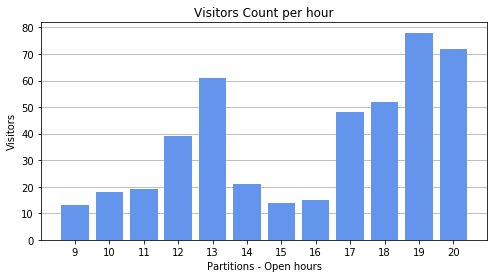

In [37]:
# bar_plot(x,y,title,x_label,y_label)

bar_plot(VALID_HOURS, count_per_hour, "Visitors Count per hour", "Partitions - Open hours","Visitors")

### Note: The data preprocessing is done by the user, the library PyDP only helps with introducing noise to the data and making it differentially private

### Private Count Per Hour

In [38]:
data = new_df.groupby('Partition').VisitorId.apply(list)  
data_list= list(data)

In [16]:
type(data_list)

list

In [43]:
# Private Count visits by hour of day

private_count_per_hour = []
epsilon = math.log(3) 

def cal_private_count(privacy_budget: float):
    for data in data_list:
        x = Count(privacy_budget)        
        count = x.quick_result(data)      # accepts list as input
        private_count_per_hour.append(count)
    return private_count_per_hour

cal_private_count(epsilon)
print(private_count_per_hour)

[13, 19, 19, 41, 62, 19, 15, 15, 48, 54, 78, 72]


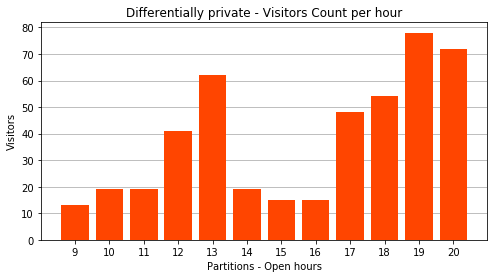

In [44]:
# private_bar_plot(x,y,title,x_label,y_label)

private_bar_plot(VALID_HOURS, private_count_per_hour, "Differentially private - Visitors Count per hour", "Partitions - Open hours","Visitors" )

The image below illustrates the results. The blue (left) bars represent the counts without anonymization while orange(right) bars correspond to the private (or anonymized) counts. You can see that the private values slightly differ from the actual ones but the overall trend is preserved. For example, you can clearly see that the restaurant is more busy during lunch and dinner time.

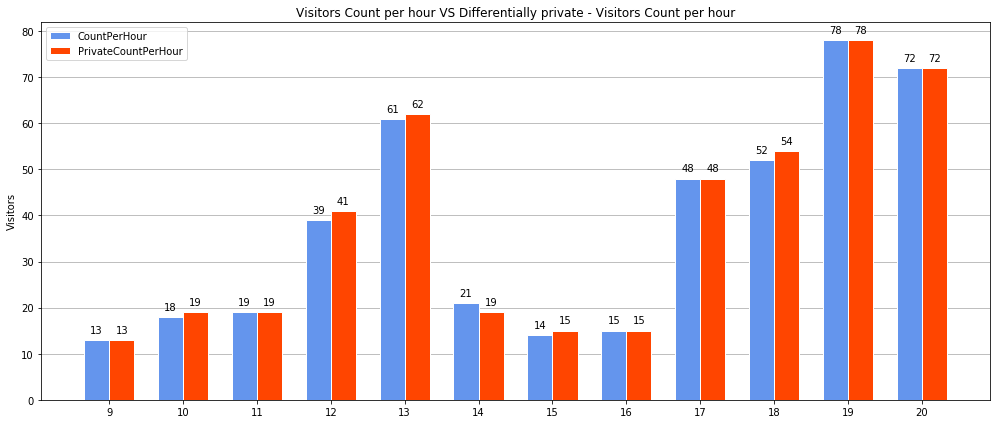

In [45]:
# compare the results
labels = VALID_HOURS
x1 = count_per_hour
x2 = private_count_per_hour

# comparison_graph(labels, x1, x2, rect1_label, rect2_label, x_label, title)
comparison_graph(labels, x1, x2, 'CountPerHour', 'PrivateCountPerHour', 'Visitors','Visitors Count per hour VS Differentially private - Visitors Count per hour'  )

Note that Differential Privacy involves adding random noise to the actual data, so your results will most likely be slightly different.

 Next, we will demonstrate how to use the library in scenarios where: 

- Visitors can contribute to multiple partitions.
- Contributed values can be greater than 1.
- Visitors can contribute to a partition multiple times.

## Count visits by day of week

The previous example made some over-simplifying assumptions. Now, let’s have a look at the use-case where visitors can contribute to multiple partitions.

Imagine Alice decides to let visitors know which days are the busiest at her restaurant. For this, she calculates how many people visit the restaurant every day of the week. For simplicity, let’s assume a visitor enters the restaurant at most once a day but multiple times a week.

Visit data for a week is stored in the **week_data.csv** file.

- *Case 1* -  once a day - multiple times a week 
- *Case 2* - once a day - max three times a week

Speaking in terms of partitions and contributions, the resulting bar chart has 7 partitions: one for each day of the week. A visitor may enter the restaurant once a day and hence contribute to a partition at most once. A visitor may enter the restaurant several times a week and hence contribute to up to 7 partitions.

In [46]:
url = 'https://raw.githubusercontent.com/OpenMined/PyDP/dev/examples/restaurant_demo/week_data.csv'
visitor_df = pd.read_csv(url,sep=",")
visitor_df.head()

,VisitorId,Time entered,Time spent (minutes),Money spent (euros),Day
0,580,9:27:00 AM,29,17,1
1,1215,9:16:00 AM,45,18,1
2,448,11:55:00 AM,12,16,1
3,125,10:47:00 AM,27,20,1
4,484,11:08:00 AM,35,13,1


In [47]:
# check the data
visitor_df[["VisitorId","Day"]].head()

,VisitorId,Day
0,580,1
1,1215,1
2,448,1
3,125,1
4,484,1


In [48]:
# Day for index - check 
print(visitor_df.loc[2849,"Day"])

7


In [49]:
#view and check 
#Visitors in Day -1 
day1 = visitor_df.loc[visitor_df["Day"] == 1]
print(day1)

# Search Visitor ID details
visitor = visitor_df.loc[visitor_df["VisitorId"] == 1215]
print(visitor)

# Count number of days visit per week > 3
print(visitor["Day"].count() > 3)

# combining the two - visit count > 3per week
print(visitor_df.loc[visitor_df["VisitorId"] == 1215]["Day"].count() > 3)

# days of visit
visitor_day= visitor_df.loc[visitor_df["VisitorId"] == 1215]["Day"]
print(visitor_day)

     VisitorId Time entered  Time spent (minutes)  Money spent (euros)  Day
0          580   9:27:00 AM                    29                   17    1
1         1215   9:16:00 AM                    45                   18    1
2          448  11:55:00 AM                    12                   16    1
3          125  10:47:00 AM                    27                   20    1
4          484  11:08:00 AM                    35                   13    1
5          514   9:11:00 AM                    34                   18    1
6          346   9:51:00 AM                    55                   25    1
7          326   9:35:00 AM                    49                   19    1
8          527  10:59:00 AM                    38                   30    1
9          180  10:57:00 AM                    51                   14    1
10         696   9:36:00 AM                    29                   19    1
11        1224   9:18:00 AM                    30                   18    1
12        10

In [50]:
day = [ {"Day_"+str(i) : 0} for i in visitor_df["Day"].unique()]
print(day)

days = [ "Day_"+str(i)  for i in visitor_df["Day"].unique() ]
print(days)

days_int = [ i for i in visitor_df["Day"].unique() ]
print(days_int)

[{'Day_1': 0}, {'Day_2': 0}, {'Day_3': 0}, {'Day_4': 0}, {'Day_5': 0}, {'Day_6': 0}, {'Day_7': 0}]
['Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7']
[1, 2, 3, 4, 5, 6, 7]


In [51]:
# Another DataFrame for maxPartitionsContributed per day
visitor_count_df = pd.DataFrame( {'VisitorId' : visitor_df["VisitorId"].unique()})
#print(visitor_count)

# Set all Days visit to 0 and Count_perWeek (<= 3) to False
def set_visitor_count0(df):
    for i in days:
        df[i] = 0
        
    df["valid_contribution"] = False
    return df

In [52]:
# Reset the count of day visit to 0

set_visitor_count0(visitor_count_df).head()

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,valid_contribution
0,580,0,0,0,0,0,0,0,False
1,1215,0,0,0,0,0,0,0,False
2,448,0,0,0,0,0,0,0,False
3,125,0,0,0,0,0,0,0,False
4,484,0,0,0,0,0,0,0,False


In [53]:
# Add Per Day visit to visitor_count_df
# 1 - present , 0 - absent

def per_day_visits(df):
    for index_no in visitor_df.index:
        day_no = visitor_df.loc[index_no,'Day']
        id_no = visitor_df.loc[index_no,'VisitorId']
        #index_val = visitor_df.loc[visitor_df["VisitorId"] == id_no].index[0]
        #print("index val : ",index_val, "day_no :", day_no)
        
        #in visitor_count_df dataframe
        visitor_index_val = df.loc[df["VisitorId"] == id_no].index[0]
        #print("New index val : ",visitor_index_val)
        visitor_day_val = df.loc[visitor_index_val, "Day_"+str(day_no)]
        #print("Day val : ",visitor_day_val)
        df.at[visitor_index_val, "Day_"+str(day_no) ] = visitor_day_val + 1
        
    return df
    

In [54]:
per_day_visits(visitor_count_df).head()  

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,valid_contribution
0,580,1,1,1,0,1,0,1,False
1,1215,1,1,0,0,0,1,1,False
2,448,1,1,0,0,0,0,0,False
3,125,1,1,1,1,1,0,0,False
4,484,1,0,0,0,0,0,0,False


In [55]:
# Day visits for VisitorId
visitor_df.loc[visitor_df['VisitorId']== 1251]['Day']

886     3
2349    6
Name: Day, dtype: int64

In [56]:
# verifying the results for per_day_visits()
visitor_count_df.loc[visitor_count_df['VisitorId']== 1251]

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,valid_contribution
721,1251,0,0,1,0,0,1,0,False


In [57]:
# valid_contribution is all set to False 
visitor_count_df.loc[visitor_count_df['valid_contribution']==True]['Day_6']

Series([], Name: Day_6, dtype: int64)

**Bounding the number of contributed partitions**

The parameter maxPartitionsContributed in Google's Java example, defines the maximum number of partitions a visitor may contribute to. You might notice that the value of maxPartitionsContributed in the example is 3 instead of 7. Why is that? Differential Privacy adds some amount of random noise to hide contributions of an individual. The more contributions an individual has, the larger the noise is. This affects the utility of the data. In order to preserve the data utility, an approximate estimate of how many times a week a person may visit a restaurant on average was made, and assumed that the value is around 3 instead of scaling the noise by the factor of 7.

**max_partitions_contributed()** limits the max contribution to the entered number, in this case 3, i.e., a visitor may contribute or visit the restaurant max 3 times in a week. The rest of the exceeding data is discarded. Everyone with contributions greater than 3 will have **"valid_contribution"** as False.


## Case 2 : Max contribution per week set to 3 times a week

In [58]:
# Check the visitors with greater than Max Contribution are marked as False

def max_partitions_contributed(max_days: int, df): 
    for index_no in df.index:
        day_count = 0
        for day_no in days_int:
            if (df.loc[index_no, "Day_"+str(day_no)] > 0 ):
                day_count = day_count + 1
                
        # check whether day count is > max_days or not
        if day_count <= max_days:
            df.at[index_no, "valid_contribution"] = True           
    return df
    

In [59]:
# max_partitions_contributed(max_days: int, df)
max_partitions_contributed(3,visitor_count_df).head() 

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,valid_contribution
0,580,1,1,1,0,1,0,1,False
1,1215,1,1,0,0,0,1,1,False
2,448,1,1,0,0,0,0,0,True
3,125,1,1,1,1,1,0,0,False
4,484,1,0,0,0,0,0,0,True


In [60]:
# create a copy visitors_maxweek DataFrame for max 3 days count
visitors_maxweek = visitor_count_df.copy()
visitors_maxweek.head()

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,valid_contribution
0,580,1,1,1,0,1,0,1,False
1,1215,1,1,0,0,0,1,1,False
2,448,1,1,0,0,0,0,0,True
3,125,1,1,1,1,1,0,0,False
4,484,1,0,0,0,0,0,0,True


In [61]:
# check index
visitors_maxweek.loc[visitor_count_df["valid_contribution"] == False].index 

Int64Index([   0,    1,    3,    5,    9,   11,   14,   15,   16,   20,
            ...
             781,  789,  803,  828,  845,  896,  952,  955,  981, 1000],
           dtype='int64', length=132)

In [62]:
# If Max contribution is greater than the desired value here 3, then, 
# remove the extra contributions from that visitors per day of week
# set the "valid_contribution" to True after the extra value has been removed.
#This might introduce some bias as when max_contribution = 3, the first 3 days will remain mostly unchanged 
# Day_4 to Day_7 count values will be effected the most.
# But, for simplicity we will go ahead with this approach.

def remove_extra_contributions(max_contribution: int, df):
    
    for index_no in df.loc[df["valid_contribution"] == False].index:
        day_count = 0
        for day_no in days_int:
            if (df.loc[index_no, "Day_"+str(day_no)] > 0 ):
                day_count = day_count + 1
                
            if day_count > max_contribution:
                df.at[index_no, "Day_"+str(day_no)] = 0
                
        df.at[index_no, "valid_contribution"] = True
            
    return df   

In [63]:
remove_extra_contributions(3,visitors_maxweek ).head()

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,valid_contribution
0,580,1,1,1,0,0,0,0,True
1,1215,1,1,0,0,0,1,0,True
2,448,1,1,0,0,0,0,0,True
3,125,1,1,1,0,0,0,0,True
4,484,1,0,0,0,0,0,0,True


In [64]:
# check index 
visitors_maxweek.loc[visitors_maxweek["valid_contribution"] == False].index 

Int64Index([], dtype='int64')

## Day wise count for both the cases

In [65]:
# Calculate the day wise count for both the cases
print(days)    
total_visitors_max3days = [] # case 2 
total_visitors_day = []      # case 1

for i in days:
    total_visitors_max3days.append(visitors_maxweek.loc[visitors_maxweek[i] > 0][i].count())  # case 2
    total_visitors_day.append(visitor_count_df.loc[visitor_count_df[i] > 0][i].count())       # case 1
    

print('Case 1: ', total_visitors_day)
print('Case 2: ',total_visitors_max3days)    


['Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7']
Case 1:  [300, 300, 400, 400, 450, 500, 500]
Case 2:  [300, 300, 400, 394, 432, 460, 407]


### Bar Plots for Case 1 
Visitors can visit one time a day and any day in a week, i.e., max 7 days in a week.

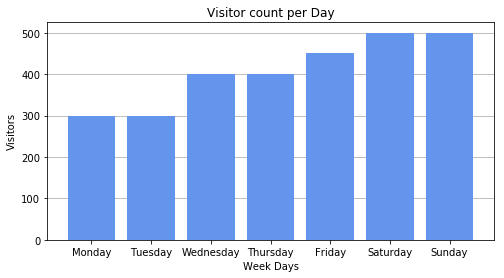

In [66]:
# bar_plot(x,y,title,x_label,y_label)
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

bar_plot(x,total_visitors_day,"Visitor count per Day","Week Days","Visitors")

### Bar Plots for Case 2 
Visitors can visit one time a day and max 3 days in a week.

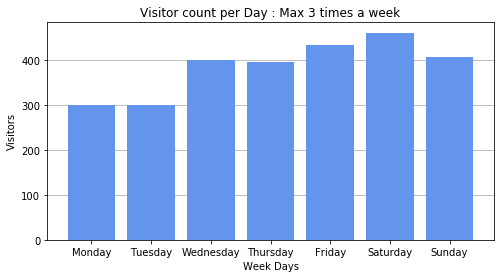

In [67]:
# bar_plot(x,y,title,x_label,y_label)
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

bar_plot(x,total_visitors_max3days,"Visitor count per Day : Max 3 times a week","Week Days","Visitors")

# Private Count for the above Cases using PyDP library

In [92]:
def cal_private_count_per_day(privacy_budget: float, data_list: list):
    private_count = []
    for data in data_list:
        x = Count(privacy_budget)        
        count = x.quick_result(data)
        private_count.append(count)
    return private_count

In [93]:
visits_case1 = []  #list for case 1 
visits_case2 = []  # list for case 2


for i in days:
    # Case 1: List for max contribution 7 days a week
    visits_case1.append(visitor_count_df.loc[visitor_count_df[i]>0][i].tolist())
    
    # Case 2: List for Max contribution 3 days a week
    visits_case2.append(visitors_maxweek.loc[visitors_maxweek[i] > 0][i].tolist())

In [94]:
# caluculate the private count 
epsilon = math.log(3)
private_count_perDay_week = cal_private_count_per_day(epsilon, visits_case1)
private_count_max3Day_week = cal_private_count_per_day(epsilon,visits_case2)

print(days) 
print("Case 1: Private Count per day in a week")
print(private_count_perDay_week)
print("Case 2: Private Count Max 3 days in a week")
print(private_count_max3Day_week)

['Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7']
Case 1: Private Count per day in a week
[298, 300, 400, 400, 450, 500, 502]
Case 2: Private Count Max 3 days in a week
[300, 302, 399, 395, 433, 459, 405]


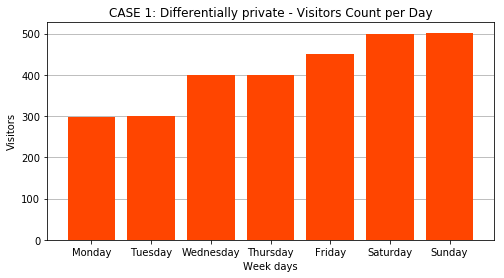

In [95]:
# private_bar_plot(x,y,title,x_label,y_label)
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

private_bar_plot(x,private_count_perDay_week,"CASE 1: Differentially private - Visitors Count per Day","Week days","Visitors")

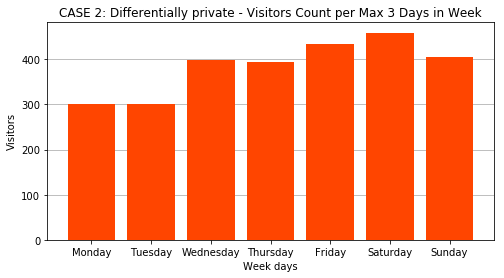

In [96]:
# private_bar_plot(x,y,title,x_label,y_label)
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

private_bar_plot(x,private_count_max3Day_week,"CASE 2: Differentially private - Visitors Count per Max 3 Days in Week","Week days","Visitors")

# Comparison between private and non-private count

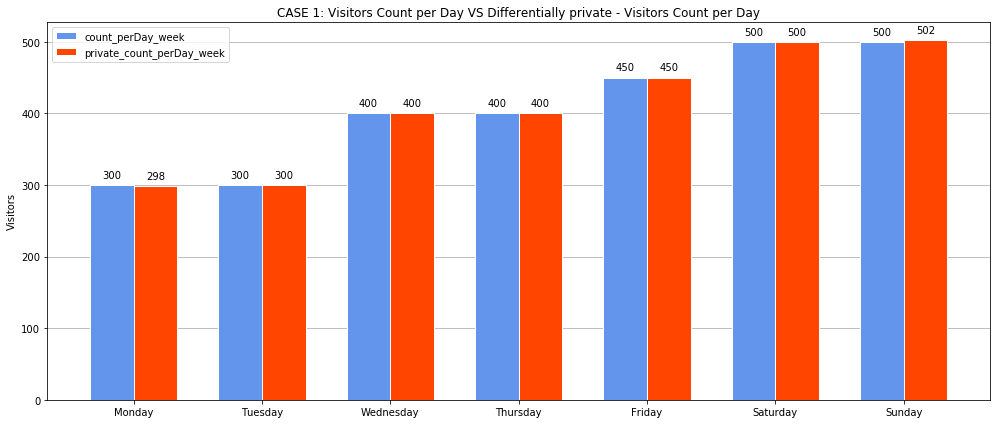

In [97]:
#Case 1 Comparison 
# if error occurs loading - reload total_visitors_day cell above
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
x1 = total_visitors_day
x2 = private_count_perDay_week

comparison_graph(labels, x1, x2, 'count_perDay_week', 'private_count_perDay_week', 'Visitors','CASE 1: Visitors Count per Day VS Differentially private - Visitors Count per Day'  )


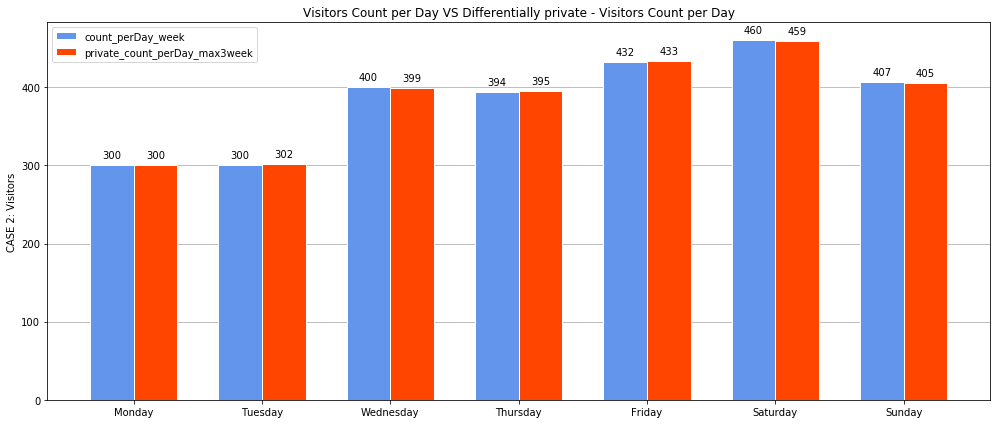

In [98]:
#Case 2 Comparison 
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
x1 = total_visitors_max3days
x2 = private_count_max3Day_week

comparison_graph(labels, x1, x2, 'count_perDay_week', 'private_count_perDay_max3week', 'CASE 2: Visitors','Visitors Count per Day VS Differentially private - Visitors Count per Day'  )


## Sum-up revenue per day of the week

The previous example demonstrates how the contributed partitions are bounded. Now, we will demonstrate how individual contributions are clamped. Imagine Alice decides to calculate the sum of the restaurant revenue per week day in a differentially private way. For this she needs to sum up the visitors’ daily spending at the restaurant. For simplicity, let’s assume a visitor enters the restaurant at most once a day but multiple times a week.

In [99]:
# MAX_CONTRIBUTED_DAYS = 4
MIN_EUROS_SPENT = 0

MAX_EUROS_SPENT = 50

epsilon = math.log(3)

In [100]:
revenue_df = pd.DataFrame( {'VisitorId' : visitor_df["VisitorId"].unique()}) 

set_visitor_count0(revenue_df).head() # returns revenue_df set days values to 0

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,valid_contribution
0,580,0,0,0,0,0,0,0,False
1,1215,0,0,0,0,0,0,0,False
2,448,0,0,0,0,0,0,0,False
3,125,0,0,0,0,0,0,0,False
4,484,0,0,0,0,0,0,0,False


In [101]:
per_day_visits(revenue_df).head() # returns revenue_df days values - 1 -> present 0 -> absent

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,valid_contribution
0,580,1,1,1,0,1,0,1,False
1,1215,1,1,0,0,0,1,1,False
2,448,1,1,0,0,0,0,0,False
3,125,1,1,1,1,1,0,0,False
4,484,1,0,0,0,0,0,0,False


In [102]:
# Add Per Day Amount to visitor_count_df
# Replace the Day attendance with the amount spent on that day

def per_day_amount(df):
    for index_no in visitor_df.index:
        day_no = visitor_df.loc[index_no,'Day']
        id_no = visitor_df.loc[index_no,'VisitorId']
        amount = visitor_df.loc[index_no,'Money spent (euros)']
        #index_val = visitor_df.loc[visitor_df["VisitorId"] == id_no].index[0]
        #print("index val : ",index_val, "day_no :", day_no)
        
        #other dataframe
        visitor_index_val = df.loc[visitor_count_df["VisitorId"] == id_no].index[0]
        #print("New index val : ",visitor_index_val)
        visitor_day_val = df.loc[visitor_index_val, "Day_"+str(day_no)]
        #print("Day val : ",visitor_day_val)
        df.at[visitor_index_val, "Day_"+str(day_no) ] = amount
        
    return df
        
per_day_amount(revenue_df).head()

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,valid_contribution
0,580,17,32,23,0,26,0,29,False
1,1215,18,28,0,0,0,36,22,False
2,448,16,35,0,0,0,0,0,False
3,125,20,47,24,26,20,0,0,False
4,484,13,0,0,0,0,0,0,False


In [103]:
max_partitions_contributed(4,revenue_df).head()  # returns revenue_df with True and False values for max contribution = 4

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,valid_contribution
0,580,17,32,23,0,26,0,29,False
1,1215,18,28,0,0,0,36,22,True
2,448,16,35,0,0,0,0,0,True
3,125,20,47,24,26,20,0,0,False
4,484,13,0,0,0,0,0,0,True


In [104]:
# Remove extra contribution from visitors_Maxweek DataFrame 
# returns visitors_Maxweek
remove_extra_contributions(4, revenue_df).head()

,VisitorId,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,valid_contribution
0,580,17,32,23,0,26,0,0,True
1,1215,18,28,0,0,0,36,22,True
2,448,16,35,0,0,0,0,0,True
3,125,20,47,24,26,0,0,0,True
4,484,13,0,0,0,0,0,0,True


In [105]:
# Calculate per day amount - Unbounded sum
# To check the difference between unbounded and bounded sum
per_day_amount = []

for day in days:  # day = day_1
    amount = revenue_df.loc[:, day ].sum()
    per_day_amount.append(amount)
    

print(days)
print(per_day_amount)

['Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7']
[8678, 8696, 12088, 12079, 13682, 16311, 16082]


In [106]:
#CAlculate Differentially private amount
def private_per_day_amount_bounded(lt):
    x = BoundedSum(epsilon,
                MIN_EUROS_SPENT,
                MAX_EUROS_SPENT,
                  4)
    return x.quick_result(lt)

In [107]:
bounded = []
private_bounded = []

for day in days:

    amount_bounded = []
    
    for index_no in revenue_df.index:
        amount = revenue_df.loc[index_no, day]
        
        if amount > MAX_EUROS_SPENT:
            amount = MAX_EUROS_SPENT
            
        if amount != 0:
            amount_bounded.append(amount)
            
    total = private_per_day_amount_bounded(amount_bounded)
    total1 = sum(amount_bounded)
    private_bounded.append(total)
    bounded.append(total1)
    
print(days)
print('Private Values:', private_bounded)   
print('Original Values:',bounded)

['Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7']
Private Values: [8489, 8715, 12120, 11969, 13489, 16198, 16014]
Original Values: [8642, 8696, 11998, 12054, 13682, 16311, 16082]


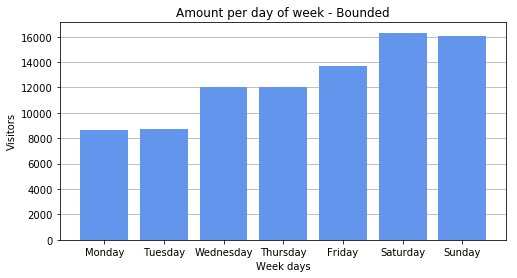

In [108]:
# bar_plot(x,y,title,x_label,y_label)
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

bar_plot(x,bounded,"Amount per day of week - Bounded","Week days","Visitors")

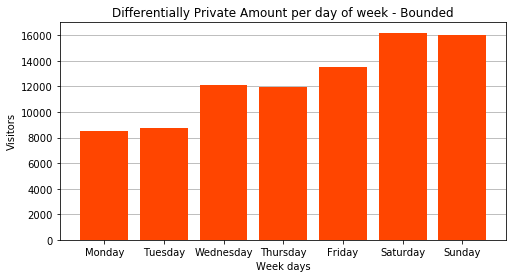

In [109]:
# private_bar_plot(x,y,title,x_label,y_label)
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

private_bar_plot(x,private_bounded,"Differentially Private Amount per day of week - Bounded","Week days","Visitors")

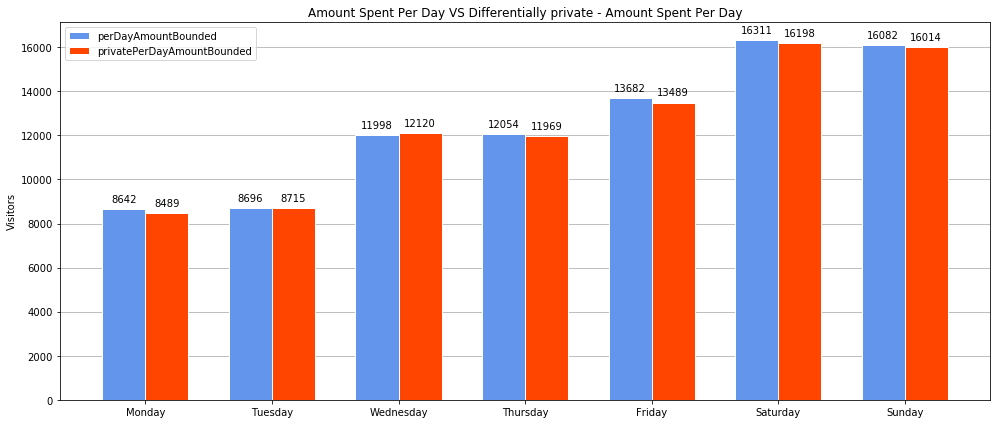

In [110]:
#Comparison graph

labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
x1 = bounded
x2 = private_bounded

comparison_graph(labels, x1, x2, 'perDayAmountBounded', 'privatePerDayAmountBounded', 'Visitors','Amount Spent Per Day VS Differentially private - Amount Spent Per Day'  )
